In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
data = pd.read_csv("https://foxweb.marist.edu/users/jf4n/DATA_FILES/drug_consumption.csv")
data.head()

,Age,Gender,Education,Country,Ethnicity,Neuroticism,Extraversion,Openness,Agreeableness,Conscientiousness,Impulsiveness,Sensation_seeing,Chocolate,Caff,Nicotine,Mild_Stimulants,Amphet,Cocaine,Crack,Stimulants,Amylnitrite,Alcohol,Benzos,Downers,Canabis,Heroin,Meth,Ketamine,Narcotics,Legalh,Ecstasy,LSD,Mushrooms,Hallucinogens,Inhalants
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,5,6,2,1,2,0,0,1,0,5,2,1,0,0,0,0,0,0,0,0,0,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,6,6,4,1,2,3,0,1,2,5,0,1,4,0,3,2,1,0,4,2,0,1,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,4,6,0,1,0,0,0,0,0,6,0,1,3,0,0,0,0,0,0,0,1,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,4,5,2,1,0,2,0,1,0,4,3,1,2,0,0,2,1,0,0,0,0,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,6,6,2,1,1,0,0,0,1,4,0,1,3,0,0,0,0,1,1,0,2,1,0


In [ ]:
X = data.iloc[:,:12]
y = data.iloc[:,33]

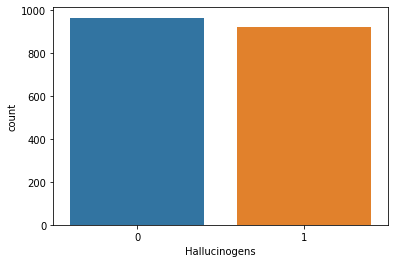

In [ ]:
dis = sns.countplot(x = y ,data = data)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=600, 
                    objective='binary:logistic',
                    silent=True, 
                    nthread=1)

In [ ]:
params = {
        'min': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
def searchCV (search_type ='random', folds=10, param_comb = 20):
  skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
   
  if search_type =='random':
    search_ = RandomizedSearchCV(xgb, 
                                       param_distributions=params, 
                                       n_iter=param_comb, 
                                       scoring='roc_auc', 
                                       n_jobs=-1, 
                                       cv=skf.split(X_train,y_train), 
                                       verbose=3, 
                                       random_state=42)
  elif search_type =='grid':
    search_ = GridSearchCV(estimator=xgb,
                                param_grid=params,
                                scoring='roc_auc',
                                n_jobs=-1,
                                cv=skf.split(X_train,y_train),
                                verbose=3) 
  return search_

In [ ]:
start_time = time.time()
folds = 10
param_comb = 20
srchCV = searchCV (search_type ='random', folds=10, param_comb = 20)
srchCV.fit(X_train, y_train)
#random_search.fit(X_train, y_train)
print(f"Execution time:{(time.time() - start_time):.2f} seg ---")

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.5min finished


Execution time:90.53 seg ---


In [ ]:
print('\n Best estimator:')
print(srchCV.best_estimator_)
print(f'\n Best AUC for {folds:d}-fold search:')
print(srchCV.best_score_ )
print('\n Best hyperparameters:')
print(srchCV.best_params_)
results = pd.DataFrame(srchCV.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 Best estimator:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=4, min=5,
              min_child_weight=1, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)

 Best AUC for 10-fold search:
0.8726284020804569

 Best hyperparameters:
{'subsample': 0.6, 'min': 5, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.8}


In [ ]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_min,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.887252,0.047057,0.008939,0.000331,0.8,10,4,1.5,0.6,"{'subsample': 0.8, 'min': 10, 'max_depth': 4, ...",0.856090,0.847139,0.892769,0.882766,0.886802,0.909091,0.837724,0.817703,0.880982,0.873154,0.868422,0.026628,13
1,0.662223,0.011921,0.008179,0.002562,1,1,3,2,0.8,"{'subsample': 1.0, 'min': 1, 'max_depth': 3, '...",0.852755,0.839242,0.891014,0.889259,0.892945,0.911899,0.838778,0.824201,0.880270,0.872621,0.869298,0.027419,9
2,0.826556,0.005652,0.006772,0.000134,0.8,10,3,5,1,"{'subsample': 0.8, 'min': 10, 'max_depth': 3, ...",0.859073,0.840295,0.896630,0.895928,0.896630,0.910495,0.832631,0.825430,0.878847,0.877424,0.871338,0.028689,5
3,0.722998,0.005194,0.007412,0.000153,0.6,10,3,1,0.6,"{'subsample': 0.6, 'min': 10, 'max_depth': 3, ...",0.860302,0.846086,0.895226,0.894524,0.889610,0.914882,0.837548,0.820688,0.883829,0.874577,0.871727,0.028231,3
4,0.915403,0.010539,0.009819,0.001771,0.6,10,4,1,0.6,"{'subsample': 0.6, 'min': 10, 'max_depth': 4, ...",0.857845,0.848894,0.894875,0.882941,0.885398,0.912601,0.835968,0.816298,0.880270,0.874755,0.868985,0.027552,10


In [ ]:
predictions = srchCV.predict(X_test)

probs = srchCV.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       190
           1       0.78      0.76      0.77       187

    accuracy                           0.77       377
   macro avg       0.77      0.77      0.77       377
weighted avg       0.77      0.77      0.77       377



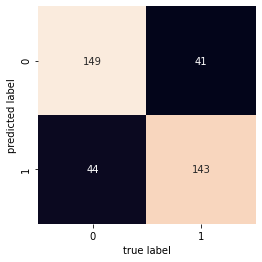

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score 
from sklearn.metrics import confusion_matrix,roc_curve, auc

In [ ]:
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

In [ ]:
roc_df = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': threshold})
roc_df

,tpr,fpr,threshold
0,0.000000,0.000000,1.941476
1,0.005435,0.000000,0.941476
2,0.005435,0.005181,0.939855
3,0.032609,0.005181,0.936666
4,0.032609,0.010363,0.936254
...,...,...,...
116,0.989130,0.854922,0.074611
117,0.994565,0.854922,0.074150
118,0.994565,0.906736,0.065851
119,1.000000,0.906736,0.065051


In [ ]:
accuracy = accuracy_score(y_test, predictions)
precision=precision_score(y_test, predictions, )
recall=recall_score(y_test, predictions)
specificity=recall_score(y_test, predictions, pos_label=0)
roc = roc_auc_score(y_test, probs)

print("\n")
print(f"Accuracy.........: {accuracy * 100.0:.4f}")
print(f"Precision........: {precision *100:.4f}")
print(f"Recall...........: {recall * 100:.4f}")
print(f"FP Rate...........:{(1-specificity) * 100:.4f}")
print(f"ROC AUC (probs)..: {roc:.6f}")

cm = confusion_matrix(y_test, predictions)
print(f"Confusion matrix.:\n {cm}")



Accuracy.........: 77.4536
Precision........: 76.7568
Recall...........: 77.1739
FP Rate...........:22.2798
ROC AUC (probs)..: 0.861568
Confusion matrix.:
 [[150  43]
 [ 42 142]]


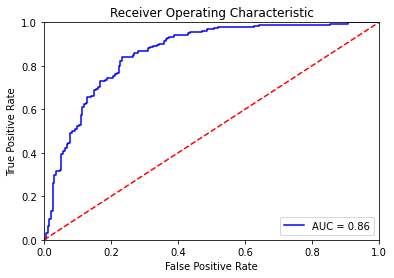

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

What classifier performed better?
The XGBoost Classifier worked better for the our set of data, it had a higher AUC value compared to random forest.